# Simple California Demo 2.0



This notebook shows how to use build a hierarchical clustering of the input features and use it to explain a single instance. This is a good way to explain a single instance when the number of input features is large.
When given a balanced partition tree PartitionExplainer has $O(M^2)$ runtime, where $M$ is the number of input features. This is much better than the $O(2^M)$ runtime of KernelExplainer.

In [6]:
import sys

import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import scipy.cluster
from xgboost import XGBRegressor

import shap

seed = 2023
np.random.seed(seed)

## Train a model

In [8]:
X, y = shap.datasets.california()
model = XGBRegressor(n_estimators=100, subsample=0.3)
model.fit(X, y)

instance = X[0:1]
references = X[1:100]

## Compute a hierarchical clustering of the input features

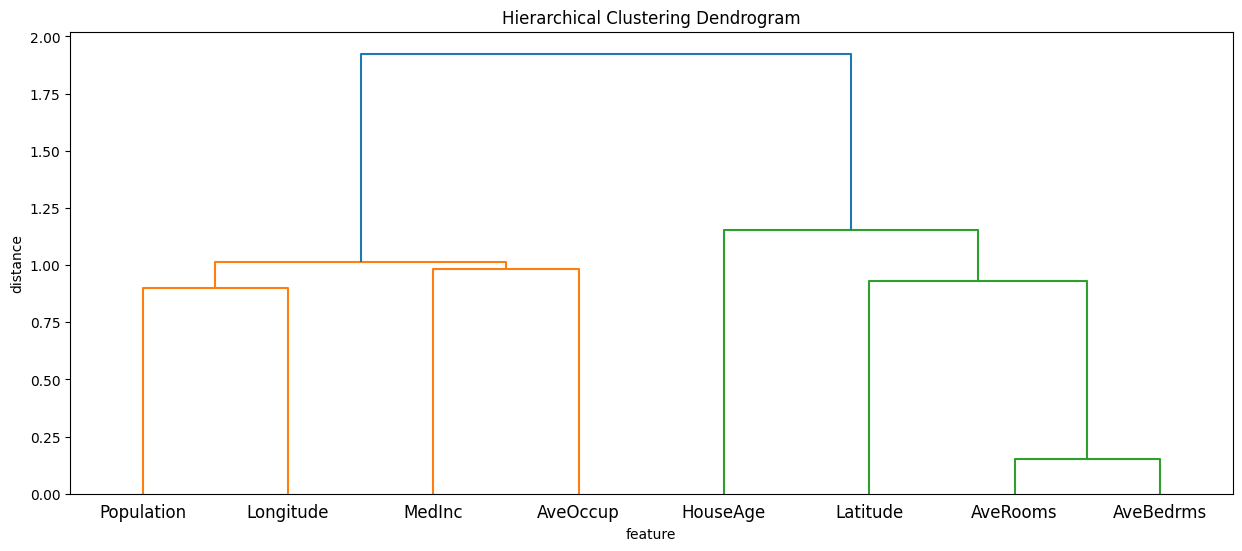

In [10]:
partition_tree = shap.utils.partition_tree(X)
plt.figure(figsize=(15, 6))
sp.cluster.hierarchy.dendrogram(partition_tree, labels=X.columns)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("feature")
plt.ylabel("distance")
plt.show()

## Explain the instance

In [12]:
 partition_hierarchy = {
    'cluster_12': {
        'cluster_11': {
            'AveOccup': 'AveOccup',
                  'cluster_plus1': {
                      'MedInc': 'MedInc'}
        },
        'cluster_9': {
            'Longitude': 'Longitude',
                   'cluster_plus2':{
            'Population': 'Population'}
        }
    },
    'cluster_13': {
        'HouseAge': 'HouseAge',
        'cluster_10': {
            'Latitude': 'Latitude',
            'cluster_8': {
                'AveBedrms': 'AveBedrms',
                'AveRooms': 'AveRooms'
            }
        }
    }
}

# partition_hierarchy = {
#             'AveOccup': 'AveOccup',
#             'MedInc': 'MedInc',
#             'Longitude': 'Longitude',
#             'Population': 'Population',
#             'HouseAge': 'HouseAge',
#             'Latitude': 'Latitude',
#             'AveBedrms': 'AveBedrms',
#             'AveRooms': 'AveRooms'
# }


In [13]:
# build a masker from partition tree
masker = shap.maskers.Partition(X, clustering=partition_tree)
partition_masker = shap.maskers.Partition(X)

# build explainer objects
#raw_explainer = shap.PartitionExplainer(model.predict, X) # we can make this syntax supportable setting the clustering method as baseline
masker_explainer = shap.PartitionExplainer(model.predict, masker)
partition_explainer = shap.PartitionExplainer(model.predict, partition_masker, partition_tree=partition_hierarchy)

# compute SHAP values
#raw_winter_values = raw_explainer(instance)
masker_winter_values = masker_explainer(instance)
partition_winter_values = partition_explainer(instance)

In [14]:
# comparison the masker and the original data sizes
print(f"X size: {sys.getsizeof(X)/1024:.2f} kB")
print(f"masker size: {sys.getsizeof(masker)} B")

X size: 1290.16 kB
masker size: 56 B


In [15]:
model.predict(instance)

array([4.4311104], dtype=float32)

## Compare to Tree SHAP

In [17]:
exact_explainer = shap.ExactExplainer(model.predict, X)
exact_shap_values = exact_explainer(instance)

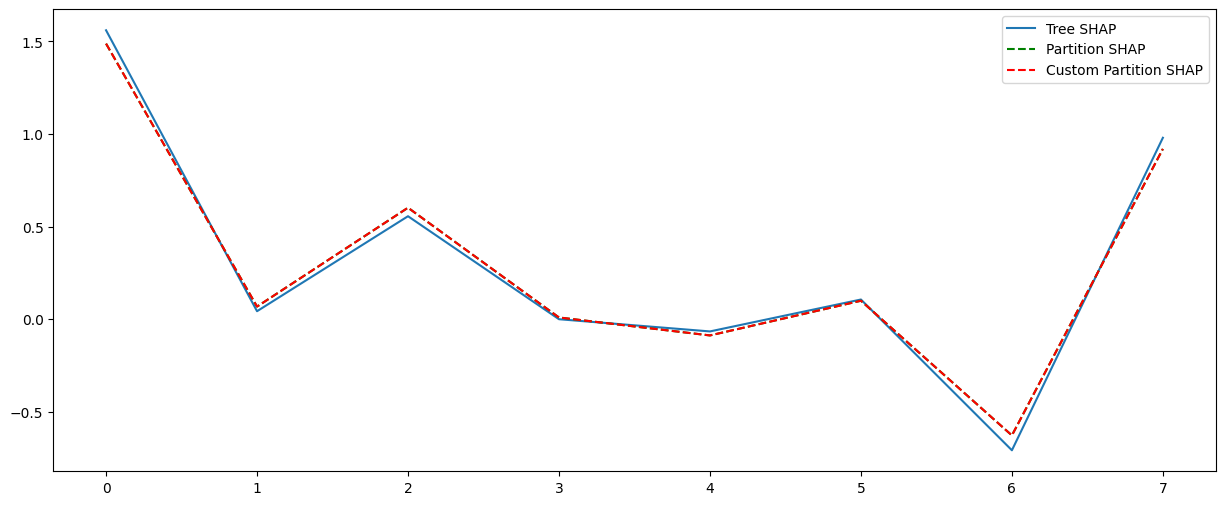

In [18]:
tree_explainer = shap.TreeExplainer(model, X)
tree_shap_values = tree_explainer(instance)

plt.figure(figsize=(15, 6))
plt.plot(tree_shap_values[0].values, label="Tree SHAP")
plt.plot(masker_winter_values[0].values, "g--", label="Partition SHAP")
plt.plot(partition_winter_values[0].values, "r--", label="Custom Partition SHAP")

plt.legend()
plt.show()

Partition SHAP values using a partition tree are nice estimation of SHAP values. The partition tree is a good way to reduce the number of input features and speed up the computation.

## Plots to explain the instance

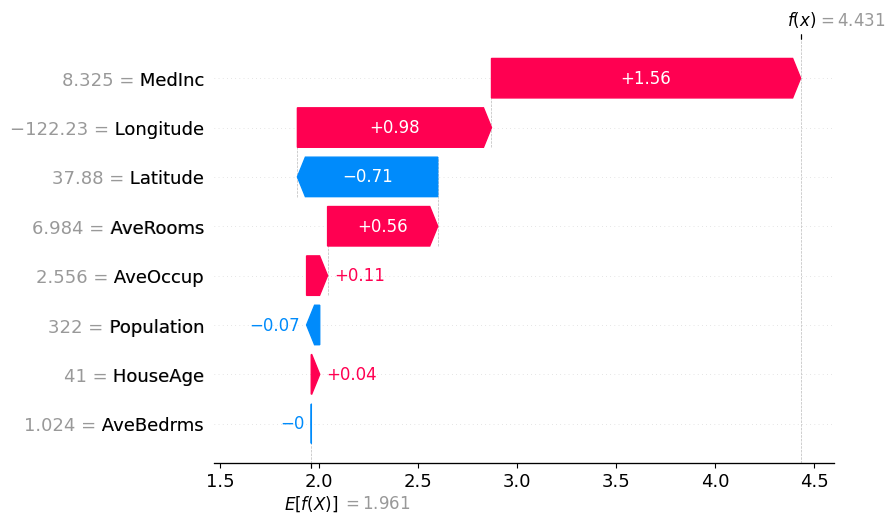

In [21]:
shap.plots.waterfall(exact_shap_values[0])

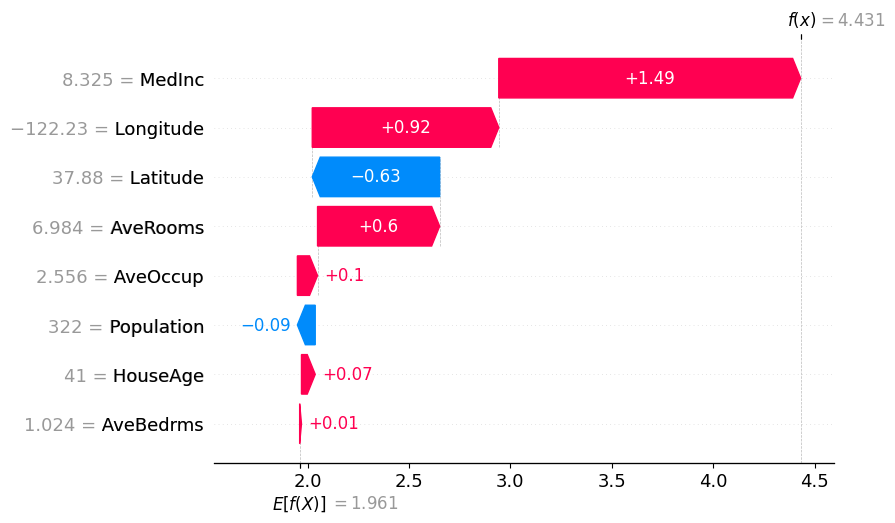

In [22]:
shap.plots.waterfall(masker_winter_values[0])

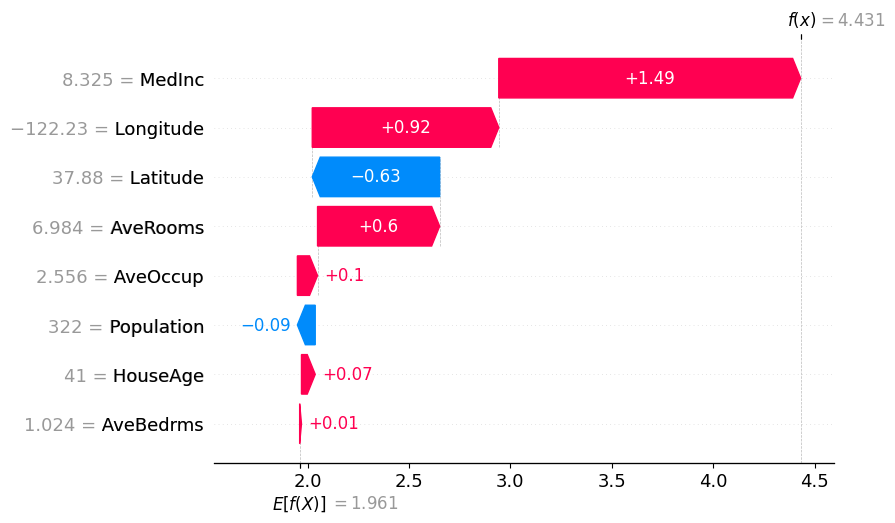

In [23]:
shap.plots.waterfall(partition_winter_values[0])

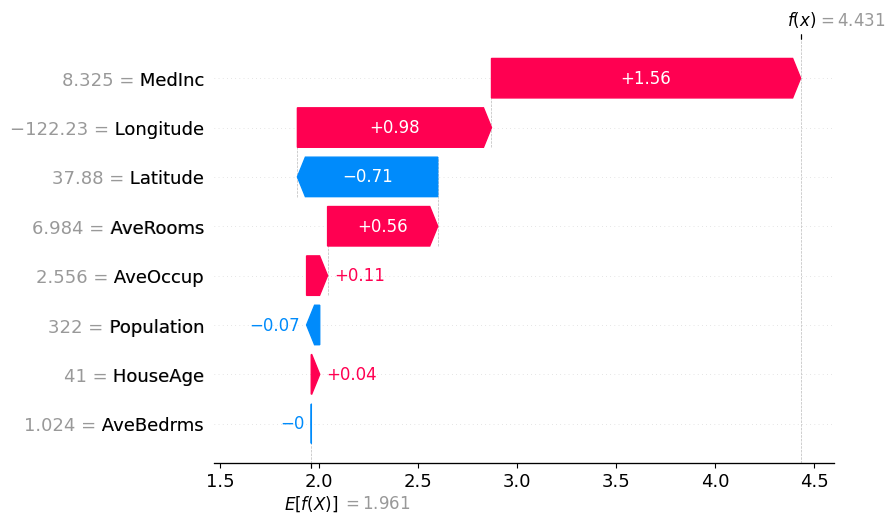

In [24]:
shap.plots.waterfall(tree_shap_values[0])

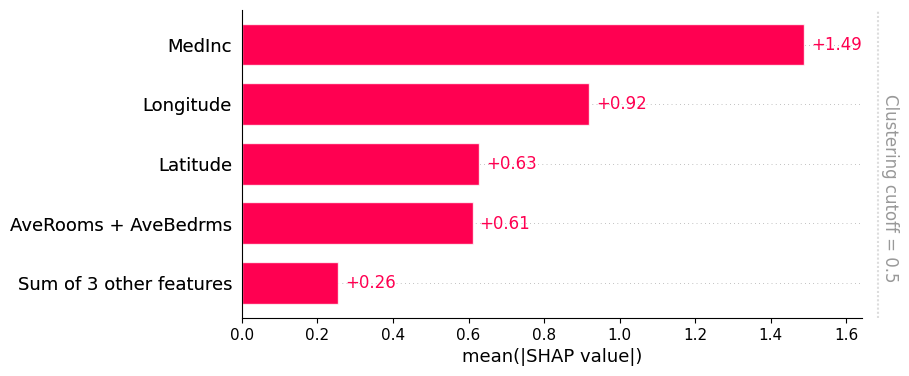

In [25]:
# Assuming the 'bar' function from your code is already defined, use it with the computed SHAP values
shap.plots.bar(partition_winter_values, max_display=5, clustering=partition_tree, show=True)


NameError: name 'dendrogram_coords' is not defined

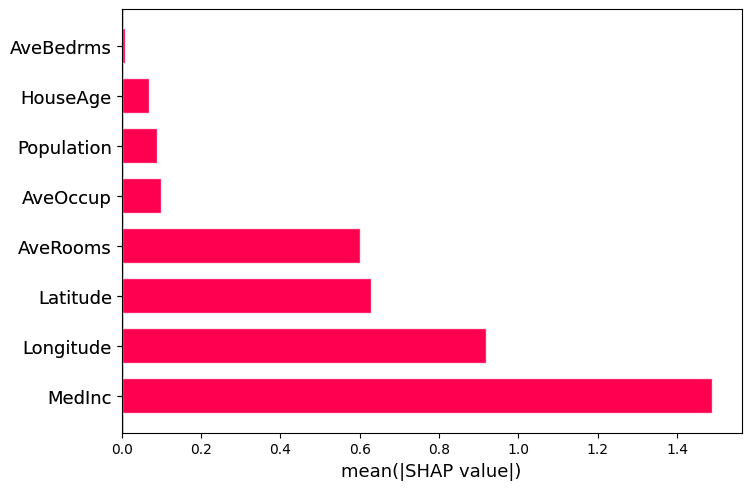

In [26]:
import shap
import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy.cluster.hierarchy import cophenet, fcluster

def bar_shap_values_clustering(shap_values, max_display=10, clustering=None, clustering_cutoff=0.5, show=True):
    if isinstance(shap_values, shap.Explanation):
        cohorts = {"": shap_values}
    elif isinstance(shap_values, shap.Cohorts):
        cohorts = shap_values.cohorts
    elif isinstance(shap_values, dict):
        cohorts = shap_values
    else:
        raise TypeError("The shap_values argument must be an Explanation object, Cohorts object, or dictionary of Explanation objects!")

    cohort_labels = list(cohorts.keys())
    cohort_exps = list(cohorts.values())

    for i, exp in enumerate(cohort_exps):
        if not isinstance(exp, shap.Explanation):
            raise TypeError("The shap_values argument must be an Explanation object, Cohorts object, or dictionary of Explanation objects!")

        if len(exp.shape) == 2:
            cohort_exps[i] = exp.abs.mean(0)
        if cohort_exps[i].shape != cohort_exps[0].shape:
            raise DimensionError("When passing several Explanation objects, they must all have the same number of feature columns!")

    features = cohort_exps[0].display_data if cohort_exps[0].display_data is not None else cohort_exps[0].data
    feature_names = cohort_exps[0].feature_names
    partition_tree = clustering if clustering is not None else getattr(cohort_exps[0], "clustering", None)

    values = np.array([cohort_exps[i].values for i in range(len(cohort_exps))])

    if len(values[0]) == 0:
        raise ValueError("The passed Explanation is empty, so there is nothing to plot.")

    if partition_tree is not None:
        if len(partition_tree.shape) != 2 or partition_tree.shape[1] != 4:
            raise TypeError("The clustering provided by the Explanation object does not seem to be a partition tree, which is all shap.plots.bar supports.")

    orig_inds = [[i] for i in range(len(values[0]))]
    orig_values = values.copy()

    if partition_tree is not None:
        dist = scipy.spatial.distance.squareform(cophenet(partition_tree))
        
        while len(values[0]) > max_display:
            merge_occurred = False
            for i in range(len(partition_tree)):
                if partition_tree[i, 2] <= clustering_cutoff:
                    ind1 = int(partition_tree[i, 0])
                    ind2 = int(partition_tree[i, 1])
                    
                    if ind1 < len(values[0]) and ind2 < len(values[0]):
                        for v in range(len(values)):
                            values[v, ind1] += values[v, ind2]
                        values = np.delete(values, ind2, axis=1)
                        orig_inds[ind1] += orig_inds[ind2]
                        del orig_inds[ind2]
                        merge_occurred = True
                        break

            if not merge_occurred:
                break

    feature_order = np.argsort(np.mean(np.abs(values), axis=0))
    feature_inds = feature_order[:max_display]
    y_pos = np.arange(len(feature_inds), 0, -1)
    feature_names_new = []

    for pos, inds in enumerate(orig_inds):
        if len(inds) == 1:
            feature_names_new.append(feature_names[inds[0]])
        else:
            full_print = " + ".join([feature_names[i] for i in inds])
            if len(full_print) <= 40:
                feature_names_new.append(full_print)
            else:
                max_ind = np.argmax(np.abs(orig_values).mean(0)[inds])
                feature_names_new.append(feature_names[inds[max_ind]] + " + %d other features" % (len(inds) - 1))
    feature_names = feature_names_new

    num_features = min(max_display, len(values[0]))

    if num_features < len(values[0]):
        num_cut = np.sum([len(orig_inds[feature_order[i]]) for i in range(num_features - 1, len(values[0]))])
        values[:, feature_order[num_features - 1]] = np.sum([values[:, feature_order[i]] for i in range(num_features - 1, len(values[0]))], 0)

    yticklabels = []
    for i in feature_inds:
        yticklabels.append(feature_names[i])
    if num_features < len(values[0]):
        yticklabels[-1] = "Sum of %d other features" % num_cut

    fig, ax = plt.subplots()
    row_height = 0.5
    fig.set_size_inches(8, num_features * row_height * np.sqrt(len(values)) + 1.5)

    ax.axvline(0, 0, 1, color="#000000", linestyle="-", linewidth=1, zorder=1)
    patterns = (None, '\\\\', '++', 'xx', '////', '*', 'o', 'O', '.', '-')
    total_width = 0.7
    bar_width = total_width / len(values)
    
    for i in range(len(values)):
        ypos_offset = -((i - len(values) / 2) * bar_width + bar_width / 2)
        ax.barh(
            y_pos + ypos_offset, values[i, feature_inds],
            bar_width, align='center',
            color=[shap.plots.colors.red_rgb if values[i, feature_inds[j]] > 0 else shap.plots.colors.blue_rgb for j in range(len(y_pos))],
            hatch=patterns[i], edgecolor=(1, 1, 1, 0.8), label=f"{cohort_labels[i]}"
        )

    ax.set_yticks(list(y_pos) + list(y_pos + 1e-8), yticklabels + [t.split('=')[-1] for t in yticklabels], fontsize=13)
    ax.set_xlabel("mean(|SHAP value|)", fontsize=13)
    
    if len(values) > 1:
        ax.legend(fontsize=12)

    tick_labels = ax.yaxis.get_majorticklabels()
    for i in range(num_features):
        tick_labels[i].set_color("#999999")

    if partition_tree is not None:
        feature_pos = np.argsort(feature_order)
        ylines, xlines = dendrogram_coords(feature_pos, partition_tree)
        xmin, xmax = ax.get_xlim()
        xlines_min, xlines_max = np.min(xlines), np.max(xlines)
        ct_line_pos = (clustering_cutoff / (xlines_max - xlines_min)) * 0.1 * (xmax - xmin) + xmax
        ax.text(
            ct_line_pos + 0.005 * (xmax - xmin), (y_pos[-1] - y_pos[0]) / 2, "Clustering cutoff = " + format_value(clustering_cutoff, '%0.02f'),
            horizontalalignment='left', verticalalignment='center', color="#999999", fontsize=12, rotation=-90
        )
        ax.axvline(ct_line_pos, color="#dddddd", dashes=(1, 1)).set_clip_on(False)

        for (xline, yline) in zip(xlines, ylines):
            if np.array(xline).max() <= clustering_cutoff and yline.max() < max_display:
                ax.plot(
                    (np.array(xline) / (xlines_max - xlines_min)) * 0.1 * (xmax - xmin) + xmax,
                    max_display - np.array(yline),
                    color="#999999"
                ).set_clip_on(False)

    plt.show() if show else plt.close()

# Usage example
bar_shap_values_clustering(partition_winter_values, max_display=10, clustering=partition_tree, clustering_cutoff=0.5, show=True)


In [ ]:
# Adjust the clustering cutoff value to see if it impacts feature merging
bar_shap_values_clustering(partition_winter_values, max_display=5, clustering=partition_tree, clustering_cutoff=0, show=True)
